# Extensive Fictitious Play (XFP)
This tutorial  demonstrates extensive fictitious play (XFP) on a zero-sum Markov game, which is more general than extensive-from game (more general than normal-form game). 

For the payoff matrix, row player is maximizer, coloumn player is minimizer.

Reference: http://proceedings.mlr.press/v37/heinrich15.html

In [1]:
import sys
sys.path.append("../..")
from mars.env.mdp import ArbitraryMDP, MDPWrapper
import numpy as np

num_states = 3
num_actions_per_player = 3
num_trans = 3

env = MDPWrapper(ArbitraryMDP(num_states=num_states, num_actions_per_player=num_actions_per_player, num_trans=num_trans))
trans_matrices = env.env.trans_prob_matrices # shape: [dim_transition, dim_state, dim_action (p1*p2), dim_state]
reward_matrices = env.env.reward_matrices # shape: [dim_transition, dim_state, dim_action (p1*p2), dim_state]

oracle_nash_v, oracle_nash_q, oracle_nash_strategies = env.NEsolver(verbose=False)
oracle_v_star = oracle_nash_v[0]

oracle_v_star = np.mean(oracle_v_star, axis=0)
print(env.observation_space, env.action_space)
# env.render()
obs = env.reset()
print(obs)
done = False
while not np.any(done):
    obs, r, done, _ = env.step([1,0])
    print(obs, r, done)
print('Average initial state value of oracle Nash equilibrium for the first player: ', oracle_v_star)


Box(0.0, 12.0, (1,), float32) Discrete(3)
[[0], [0]]
[[5], [5]] [0.5610583525729109, -0.5610583525729109] [False, False]
[[6], [6]] [-0.7261994566288021, 0.7261994566288021] [False, False]
[[9], [9]] [-0.8460871060267345, 0.8460871060267345] [True, True]
Average initial state value of oracle Nash equilibrium for the first player:  -0.29607107415447115


/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:26: UserWarning: Converting G to a CSC matrix; may take a while.
  warn("Converting G to a CSC matrix; may take a while.")
/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:29: UserWarning: Converting A to a CSC matrix; may take a while.
  warn("Converting A to a CSC matrix; may take a while.")


In [2]:
print(np.array(oracle_nash_strategies).shape)
oracle_max_policy = np.array(oracle_nash_strategies)[:, :, 0, :]
print(oracle_max_policy.shape)

(3, 3, 2, 3)
(3, 3, 3)


In [6]:
# test 

def create_expand_Q():
    """
    Returns:
    [   [state_dim, action_dim, action_dim],
        [state_dim, action_dim, action_dim, state_dim, action_dim, action_dim],
        [state_dim, action_dim, action_dim, state_dim, action_dim, action_dim, state_dim, action_dim, action_dim],
        ...
    ]
    """
    values = []
    intial_dim = [num_states, num_actions_per_player, num_actions_per_player]
    for i in range(num_trans):
        value =  (1./num_actions_per_player) * np.ones(intial_dim)
        # incremental shape
        intial_dim.extend([num_states, num_actions_per_player, num_actions_per_player])
        values.append(value)

    return values

def create_expand_policy():
    """
    Returns:
    [   [state_dim, action_dim],
        [state_dim, action_dim, action_dim, state_dim, action_dim],
        [state_dim, action_dim, action_dim, state_dim, action_dim, action_dim, state_dim, action_dim],
        ...
    ]
    """
    policies = []
    intial_dim = [num_states]
    for i in range(num_trans):
        policy =  (1./num_actions_per_player) * np.ones((*intial_dim, num_actions_per_player))
        # incremental shape
        intial_dim.extend([num_actions_per_player, num_actions_per_player, num_states])
        policies.append(policy)

    return policies

def create_expand_value():
    """
    Returns:
    [   [state_dim],
        [state_dim, action_dim, action_dim, state_dim],
        [state_dim, action_dim, action_dim, state_dim, action_dim, action_dim, state_dim],
        ...
    ]    
    """
    values = []
    intial_dim = [num_states]
    for i in range(num_trans):
        value =  (1./num_actions_per_player) * np.ones(intial_dim)
        # incremental shape
        intial_dim.extend([num_actions_per_player, num_actions_per_player, num_states])
        values.append(value)

    return values

def broadcast_shape(input, output_shape):
    """ broadcast input to have the same shape as output_to_be """
    len_input_shape = len(np.array(input).shape)
    incrs_shape = output_shape[:-len_input_shape]+len_input_shape*(1,)
    output = np.tile(input, incrs_shape)
    return output



def best_response_value(trans_prob_matrices, reward_matrices, policy, num_actions, side='max'):
    """
    Formulas for calculating best response values:
    1. Nash strategies: (\pi_a^*, \pi_b^*) = \min \max Q(s,a,b), 
        where Q(s,a,b) = r(s,a,b) + \gamma \min \max Q(s',a',b') (this is the definition of Nash Q-value);
    2. Best response (of max player) value: Br V(s) = \min_b \pi(s,a) Br Q(s,a,b)  (Br Q is the oracle best response Q value)
    """
    br_v = create_expand_value()
    br_q = create_expand_Q()

    for i in range(num_trans-1, -1, -1):  # inverse indexing
        tm = trans_matrices[i]
        rm = reward_matrices[i]

        rm_ = np.array(rm).reshape(num_states, num_actions_per_player, num_actions_per_player, num_states)
        tm_ = np.array(tm).reshape(num_states, num_actions_per_player, num_actions_per_player, num_states)
        expand_rm = broadcast_shape(rm_, br_q[i].shape+(num_states,))
        if i == num_trans-1:
            expand_tm = broadcast_shape(tm_, expand_rm.shape)
            br_q[i] =  np.sum(expand_rm*expand_tm, axis=-1)
        else:
            print(br_v[i+1])
            v = br_v[i+1]
            v_before_trans = expand_rm + v  # expand_rm and v are same shape
            expand_tm = broadcast_shape(tm_, v_before_trans.shape)  # get the same shape as v_before_trans
            br_q[i] = np.sum(v_before_trans*expand_tm, axis=-1)  # only sum over last dim: state

        if side == 'max':
            mu_dot_q = np.einsum('...i, ...ij->...j', policy[i], br_q[i])
            br_v[i] = np.min(mu_dot_q, axis=-1)
        else:
            q_dot_nu = np.einsum('...ij, ...j->...i', br_q[i], policy[i])
            br_v[i] = np.max(q_dot_nu, axis=-1)         

    avg_init_br_v = -np.mean(br_v[0])  # average best response value of initial states; minus for making it positive
    return avg_init_br_v

expand_p = create_expand_policy()
test_p=[] # make the oracle nash to be expand policy shape
for p, o in zip(expand_p, oracle_max_policy):
    tp = broadcast_shape(o, p.shape)
    print(tp.shape)
    test_p.append(tp)
    
best_response_value(trans_matrices, reward_matrices, test_p, num_actions_per_player)

(3, 3)
(3, 3, 3, 3, 3)
(3, 3, 3, 3, 3, 3, 3, 3)
[[[[[[[ 0.05124187 -0.17762759  0.28158846]
      [ 0.05124187 -0.17762759  0.28158846]
      [ 0.05124187 -0.17762759  0.28158846]]

     [[ 0.05124187 -0.17762759  0.28158846]
      [ 0.05124187 -0.17762759  0.28158846]
      [ 0.05124187 -0.17762759  0.28158846]]

     [[ 0.05124187 -0.17762759  0.28158846]
      [ 0.05124187 -0.17762759  0.28158846]
      [ 0.05124187 -0.17762759  0.28158846]]]


    [[[ 0.05124187 -0.17762759  0.28158846]
      [ 0.05124187 -0.17762759  0.28158846]
      [ 0.05124187 -0.17762759  0.28158846]]

     [[ 0.05124187 -0.17762759  0.28158846]
      [ 0.05124187 -0.17762759  0.28158846]
      [ 0.05124187 -0.17762759  0.28158846]]

     [[ 0.05124187 -0.17762759  0.28158846]
      [ 0.05124187 -0.17762759  0.28158846]
      [ 0.05124187 -0.17762759  0.28158846]]]


    [[[ 0.05124187 -0.17762759  0.28158846]
      [ 0.05124187 -0.17762759  0.28158846]
      [ 0.05124187 -0.17762759  0.28158846]]

     [[ 0.

0.2960710744766214

In [3]:
import copy

def sample_from_categorical(dist):
    """
    sample once from a categorical distribution, return the entry index.
    dist: should be a list or array of probabilities for a categorical distribution
    """
    sample_id = np.argmax(np.random.multinomial(1, dist))
    sample_prob = dist[sample_id]
    return sample_id, sample_prob

def unified_state(s):
    unified_s = s[0]%num_states
    return unified_s

# def get_sequence_encoding_id(observed_seq):
#     # sequence encoding id = s1 + a1*S + a2*S*A + s2*S*A*A + a2*S*A*A*S + ...
#     id = 0
#     coef = 1
#     coef_multipliers = [num_states, num_actions_per_player, num_actions_per_player]
#     len_coef_multipliers = len(coef_multipliers)
#     j = 0
#     for o in observed_seq:
#         id += coef * o
#         coef = coef*coef_multipliers[j%len_coef_multipliers]
#     return id

def create_expand_policy(zero_ini=False):
    """
    Returns:
    [   [state_dim, action_dim],
        [state_dim, action_dim, action_dim, state_dim, action_dim],
        [state_dim, action_dim, action_dim, state_dim, action_dim, action_dim, state_dim, action_dim],
        ...
    ]
    """
    policies = []
    intial_dim = [num_states]
    for i in range(num_trans):
        if zero_ini:
            policy =  (1./num_actions_per_player) * np.zeros((*intial_dim, num_actions_per_player))
        else:
            policy =  (1./num_actions_per_player) * np.ones((*intial_dim, num_actions_per_player))
        # incremental shape
        intial_dim.extend([num_actions_per_player, num_actions_per_player, num_states])
        policies.append(policy)

    return policies

def create_expand_value():
    """
    Returns:
    [   [state_dim],
        [state_dim, action_dim, action_dim, state_dim],
        [state_dim, action_dim, action_dim, state_dim, action_dim, action_dim, state_dim],
        ...
    ]    
    """
    values = []
    intial_dim = [num_states]
    for i in range(num_trans):
        value =  (1./num_actions_per_player) * np.ones(intial_dim)
        # incremental shape
        intial_dim.extend([num_actions_per_player, num_actions_per_player, num_states])
        values.append(value)

    return values

def create_expand_Q():
    """
    Returns:
    [   [state_dim, action_dim, action_dim],
        [state_dim, action_dim, action_dim, state_dim, action_dim, action_dim],
        [state_dim, action_dim, action_dim, state_dim, action_dim, action_dim, state_dim, action_dim, action_dim],
        ...
    ]
    """
    values = []
    intial_dim = [num_states, num_actions_per_player, num_actions_per_player]
    for i in range(num_trans):
        value =  (1./num_actions_per_player) * np.ones(intial_dim)
        # incremental shape
        intial_dim.extend([num_states, num_actions_per_player, num_actions_per_player])
        values.append(value)

    return values

def get_posterior_policy(policy_set, meta_prior, likelihood):
    posterior_policy = create_expand_policy(zero_ini=True)  # zero initiate to sum later
    num_policies = len(policy_set)
    denom = meta_prior @ likelihood  # [#policy] * [#policy, H] -> [H]
    for pi_i, rho_i, likelihood_per_policy in zip(policy_set, meta_prior, likelihood):  # loop over policy
        for i, (p, d, l) in enumerate(zip(pi_i, denom, likelihood_per_policy)): # loop over transition
            posterior_policy[i] += np.array(p*rho_i*l/d)  # sum over policies in mixture

    return posterior_policy

def broadcast_shape(input, output_shape):
    """ broadcast input to have the same shape as output_to_be """
    len_input_shape = len(np.array(input).shape)
    incrs_shape = output_shape[:-len_input_shape]+len_input_shape*(1,)
    output = np.tile(input, incrs_shape)
    return output

def get_best_response_policy(player, prob_seq):
    given_policy = get_posterior_policy(player['policy_set'], player['meta_strategy'], prob_seq)
    br_policy = create_expand_policy()  # best response policy
    br_v = create_expand_value()
    br_q = create_expand_Q()

    for i in range(num_trans-1, -1, -1):  # inverse indexing
        tm = trans_matrices[i]
        rm = reward_matrices[i]

        rm_ = np.array(rm).reshape(num_states, num_actions_per_player, num_actions_per_player, num_states)
        tm_ = np.array(tm).reshape(num_states, num_actions_per_player, num_actions_per_player, num_states)

        expand_rm = broadcast_shape(rm_, br_q[i].shape+(num_states,))  # broadcast the shape of reward matrix to be expand Q shape plus additional state dimension
        if i == num_trans-1:
            expand_tm = broadcast_shape(tm_, expand_rm.shape)
            br_q[i] =  np.sum(expand_rm*expand_tm, axis=-1)
        else:
            v = br_v[i+1]
            v_before_trans = expand_rm + v  # expand_rm and v are same shape
            expand_tm = broadcast_shape(tm_, v_before_trans.shape)  # get the same shape as v_before_trans
            br_q[i] = np.sum(v_before_trans*expand_tm, axis=-1)  # only sum over last dim: state

        if player['side'] == 'max':
            mu_dot_q = np.einsum('...i, ...ij->...j', given_policy[i], br_q[i])
            arg_id = np.argmin(mu_dot_q, axis=-1)  # min player takes minimum as best response against max player's policy
            br_v[i] = np.min(mu_dot_q, axis=-1)
        else:
            q_dot_nu = np.einsum('...ij, ...j->...i', br_q[i], given_policy[i])
            arg_id = np.argmax(q_dot_nu, axis=-1)   # vice versa    
            br_v[i] = np.max(q_dot_nu, axis=-1)     

        br_policy[i] = (np.arange(num_actions_per_player) == arg_id[...,None]).astype(int)  # from extreme (min/max) idx to one-hot simplex

        # print(br_policy[i].shape, br_q[i].shape)

    return br_policy

def best_response_value(trans_prob_matrices, reward_matrices, policy, num_actions, side='max'):
    """
    Formulas for calculating best response values:
    1. Nash strategies: (\pi_a^*, \pi_b^*) = \min \max Q(s,a,b), 
        where Q(s,a,b) = r(s,a,b) + \gamma \min \max Q(s',a',b') (this is the definition of Nash Q-value);
    2. Best response (of max player) value: Br V(s) = \min_b \pi(s,a) Br Q(s,a,b)  (Br Q is the oracle best response Q value)
    """
    br_v = create_expand_value()
    br_q = create_expand_Q()

    for i in range(num_trans-1, -1, -1):  # inverse indexing
        tm = trans_matrices[i]
        rm = reward_matrices[i]

        rm_ = np.array(rm).reshape(num_states, num_actions_per_player, num_actions_per_player, num_states)
        tm_ = np.array(tm).reshape(num_states, num_actions_per_player, num_actions_per_player, num_states)
        expand_rm = broadcast_shape(rm_, br_q[i].shape+(num_states,))
        if i == num_trans-1:
            expand_tm = broadcast_shape(tm_, expand_rm.shape)
            br_q[i] =  np.sum(expand_rm*expand_tm, axis=-1)
        else:
            v = br_v[i+1]
            v_before_trans = expand_rm + v  # expand_rm and v are same shape
            expand_tm = broadcast_shape(tm_, v_before_trans.shape)  # get the same shape as v_before_trans
            br_q[i] = np.sum(v_before_trans*expand_tm, axis=-1)  # only sum over last dim: state

        if side == 'max':
            mu_dot_q = np.einsum('...i, ...ij->...j', policy[i], br_q[i])
            br_v[i] = np.min(mu_dot_q, axis=-1)
        else:
            q_dot_nu = np.einsum('...ij, ...j->...i', br_q[i], policy[i])
            br_v[i] = np.max(q_dot_nu, axis=-1)         

    avg_init_br_v = -np.mean(br_v[0])  # average best response value of initial states; minus for making it positive
    return avg_init_br_v

def get_best_response_value(player):
    policy_set = player['policy_set']
    meta_strategy = player['meta_strategy']
    per_policy_exploits = []
    for p in policy_set:
        per_policy_exploits.append(best_response_value(trans_matrices, reward_matrices, p, num_actions_per_player, player['side']))
    per_policy_exploits = np.array(per_policy_exploits)
    exploitability = per_policy_exploits @ meta_strategy  # average over policy set weighted by meta strategy

    return exploitability

def sample_policy(policy_set, dist):
    policy_id, _ = sample_from_categorical(dist)
    policy = policy_set[policy_id]   
    return policy 

# test_policy = create_expand_policy() 
# get_best_response(test_policy)

def xfp(env, save_path, solve_episodes = 1000):

    ini_max_policy = create_expand_policy()
    ini_min_policy = create_expand_policy()
    max_player = {
        'side': 'max',
        'policy_set': [ini_max_policy],
        'meta_strategy': np.array([1.])
    }
    min_player = {
        'side': 'min',
        'policy_set': [ini_min_policy],
        'meta_strategy': np.array([1.])
    }

    max_side_q_table = create_expand_Q()
    min_side_q_table = create_expand_Q()
 
    print('policy shape: ')
    for p in ini_max_policy:
        print(p.shape)
    print('Q table shape: ')
    for q in max_side_q_table:
        print(q.shape)

    exploitability_records = []

    for i in range(solve_episodes):
        s = env.reset()
        done = False
        max_player_observed_sequence = []
        min_player_observed_sequence = []
        max_player_action_prob_sequence = [[] for _ in max_player['policy_set']]
        min_player_action_prob_sequence = [[] for _ in min_player['policy_set']]
        shared_sequence_before_actions = []
        step = 0

        # sample policy from meta strategy for the current episode
        max_policy = sample_policy(max_player['policy_set'], max_player['meta_strategy'])
        min_policy = sample_policy(min_player['policy_set'], min_player['meta_strategy'])

        while not np.any(done):    
            # get observed sequence
            max_player_observed_sequence.extend([unified_state(s[0])])
            min_player_observed_sequence.extend([unified_state(s[1])])
            shared_sequence_before_actions = copy.deepcopy(max_player_observed_sequence)

            max_policy_to_choose = max_policy[step][tuple(max_player_observed_sequence)]  # a=np.ones([1,2]), b=(0,0), a[b] -> 1.
            min_policy_to_choose = min_policy[step][tuple(min_player_observed_sequence)]

            # choose action
            max_action, max_action_prob = sample_from_categorical(max_policy_to_choose)
            min_action, min_action_prob = sample_from_categorical(min_policy_to_choose)

            # roullout info for mixture policy
            if i % 2 == 0:  # update min player side
                for p_id, p in enumerate(max_player['policy_set']):  # get trajectory probabilities for each policy in policy set
                    max_p = p[step][tuple(max_player_observed_sequence)]
                    # _, max_a_prob = sample_from_categorical(max_p) # this is wrong
                    max_a_prob = max_p[max_action]  # get the probability of real action (rollout) under each policy in policy set
                    if step == 0:
                        max_player_action_prob_sequence[p_id].append(max_a_prob)
                    else:
                        max_player_action_prob_sequence[p_id].append(max_player_action_prob_sequence[p_id][-1]*max_a_prob)  # [p1, p1p2, p1p2p3, ...]
            else:
                for p_id, p in enumerate(min_player['policy_set']):
                    min_p = p[step][tuple(min_player_observed_sequence)]
                    # _, min_a_prob = sample_from_categorical(min_p)  # this is wrong
                    min_a_prob = min_p[min_action]  # get the probability of real action (rollout) under each policy in policy set
                    if step == 0:
                        min_player_action_prob_sequence[p_id].append(min_a_prob)
                    else:
                        min_player_action_prob_sequence[p_id].append(min_player_action_prob_sequence[p_id][-1]*min_a_prob)  # [p1, p1p2, p1p2p3, ...]

            action = [max_action, min_action]
            max_player_observed_sequence.extend(action)
            min_player_observed_sequence.extend(action)

            s_, r, done, _  = env.step(action)  
            s = s_

            step += 1
        
        if i % 2 == 0:  # update min player side
            new_policy = get_best_response_policy(max_player, np.array(max_player_action_prob_sequence))  # get best response against the max player, max_player_action_prob_sequence: [#policies, H]
            min_player['policy_set'].append(new_policy) # add new policy to policy set to form mixture
            num_policies = len(min_player['policy_set'])
            min_player['meta_strategy'] = 1./num_policies*np.ones(num_policies)
        else: 
            new_policy = get_best_response_policy(min_player, np.array(min_player_action_prob_sequence)) # get best response against the min player
            max_player['policy_set'].append(new_policy) # add new policy to policy set to form mixture
            num_policies = len(max_player['policy_set'])
            max_player['meta_strategy'] = 1./num_policies*np.ones(num_policies)

        if i % 10 == 0:
            exploitability = get_best_response_value(max_player)  # best response of the max player
            print(f'itr: {i}, exploitability: {exploitability}', )
            exploitability_records.append(exploitability)
            np.save(save_path, exploitability_records)

save_path = 'xfp_exp.npy'
xfp(env, save_path, solve_episodes=3)

policy shape: 
(3, 3)
(3, 3, 3, 3, 3)
(3, 3, 3, 3, 3, 3, 3, 3)
Q table shape: 
(3, 3, 3)
(3, 3, 3, 3, 3, 3)
(3, 3, 3, 3, 3, 3, 3, 3, 3)
itr: 0, exploitability: 0.7608750685387422


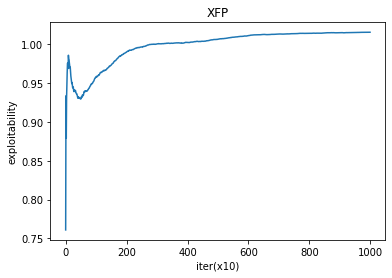

In [76]:
import matplotlib.pyplot as plt

exp_data = np.load(save_path)
plt.title('XFP')
plt.xlabel('iter(x10)')
plt.ylabel('exploitability')
plt.plot(exp_data)


In [4]:
a=np.ones([1,2])
b=np.ones(2)
a@b

array([2.])